# Goal

Can the data answer the question?

-- DS: optimise customer experience by tailoring cnotent to user needs (identify behaviour patterns)

-- ML: difficulty finding content (identify 404 patterns) (identify opportunity to improve)

## Understanding variables

Parameters described here: https://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html

### Load data to dataframe

Declaring analysis variables

In [2]:
import pandas as pd
import numpy as np
import os
import re

folder_raw_data = '../data/raw'
folder_clean_data = '../data/cleaned'
symbols_dirty = re.compile(' -0400| -|\[|\]')
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

Need to clean data from unnecessary dashes so the tsv parsing would be more straightforward.

In [3]:
def clean_raw_logs(file):
    with open(folder_clean_data + '/' + file, 'w', encoding=raw_encoding) as c:
        with open(folder_raw_data + '/' + file, 'r', encoding=raw_encoding) as r:
            for log_line in r:
                log_line = symbols_dirty.sub('', log_line)
                c.write(log_line)

Ensuring adherence to data type

In [4]:
def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

Loading the raw logs and converting in an expected dataframe output

In [5]:
def load_logs():
    files = os.listdir(folder_raw_data)
    files = [file for file in files if os.path.isfile(folder_raw_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        clean_raw_logs(file)
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_log = apply_data_type(df_log)
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return df_logs

df_loaded_logs = load_logs()


/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_38959/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_38959/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


In [6]:
df_loaded_logs.head()

,host,timestamp,request,response,bytes
0,199.72.81.55,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085
3,burger.letters.com,1995-07-01 00:00:11,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179


In [7]:
df_loaded_logs.dtypes

host         object
timestamp    object
request      object
response     object
bytes        object
dtype: object

## Clean dataset and identify features

-- refactor URL

-- variable selection (create new variable indicators)

-- removing rows with null values

-- identify outliers?

Identifying important variables in terms of answering the questions:
1. *host*: identifying requester (to be used for grouping later).
2. *timestamp*: indicator for specific times where experience was bad. 
    * To be used for grouping per day, hour, minutes. 
    * Year is irrelevant (as dataset is limited), but will be kept for flexibility.
3. *request*: identifying the pages viewed/requested.
    * Request method
    * URL traversal path
    * Page OR Resource OR None
    * HTTP/1.0 is irrelevant (doesn't give insight because all requests use it for this dataset)
4. *response*: identifies response codes
    * nominal: success, redirect, not found
    * more indicator may be needed to identify points for improvement. refer to https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
5. *bytes*: marginally irrelevant, except for explaining why certain pages may take a long time to load (however there are no other captured information available to validate this).
    * threshold indicator to build case for potential point for improvement: CDN

These will then be formed to data features

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

folder_clean_data = '../data/cleaned'
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

def load_cleaned_logs():
    files = os.listdir(folder_clean_data)
    files = [file for file in files if os.path.isfile(folder_clean_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return apply_data_type(df_logs)

df_cleaned_logs = load_cleaned_logs()
df_cleaned_logs.nunique(axis=0)

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_82787/610457873.py:23: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_82787/610457873.py:23: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


host          137979
timestamp    2075518
request        32845
response          15
bytes          16502
dtype: int64

### Host

* Insight idea: categorise the type of visitor based on url (e.g. government, education, commercial, etc)
* Add Domain column

In [2]:
def get_visitor_domain(url):
    try:
        domain_index = url.rindex('.')
        domain = str(url[(domain_index + 1) :])
        if domain.isdigit():
            domain = None
    except:
        domain = None
    return domain

def categorise_visitor(domain):
    switcher = {
        'net': 'network',
        'com': 'commercial',
        'org': 'organisation',
        'edu': 'education',
        'gov': 'government',
        'int': 'international',
    }
    domain_length = len(domain)
    try:
        if domain_length == 2:
            category = 'country'
        elif domain_length == 3:
            category = switcher.get(domain, 'unknown')
        else:
            category = 'unknown'
    except:
        category = 'unknown'
    return category

In [3]:
# create a new df to show who are the visitors
df_visitors = pd.DataFrame(df_cleaned_logs['host'])

# identify visitor profile through domain
df_visitors['domain'] = df_visitors['host'].apply(get_visitor_domain).map(lambda x: str(x))
print('unique domains: ', df_visitors['domain'].unique())

df_visitors['category'] = df_visitors['domain'].apply(categorise_visitor).map(lambda x: str(x))
df_visitors.nunique(axis=0)

unique domains:  ['None' 'net' 'com' 'jp' 'au' 'edu' 'ca' 'org' 'gov' 'us' 'nz' 'uk' 'kr'
 'ch' 'br' 'sg' 'it' 'mil' 'mx' 'nl' 'be' 'za' 'fr' 'de' 'my' 'tw' 'at'
 'fi' 'se' 'id' 'il' 'es' 'no' 'int' 'su' 'ph' 'ie' 'th' 'gr' 'pt' 'dk'
 'kw' 'ru' 'cl' 'cz' 'lv' 'arpa' 'lu' 'cr' 'co' 'tr' 'hr' 'bm' 'ua' 've'
 'si' 'cn' 'ro' 'pl' 'hk' 'sk' 'is' 'ec' 'hu' 'gb' 'sa' 'li' 'ar' 'pa'
 'pr' 'jm' 'in' 'ee' 'do' 'pe' 'fj' 'uy' 'xom' 'go' 'eg' 'ge' 'p' 'microd'
 'mt' 'keri' 'rom' 'hps' 'gl' 'gu' 'cy' 'eecs' 'line4' 'line5' 'lt']


host        137979
domain          94
category         8
dtype: int64

#### Top visitors (ranked)

In [4]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['host'])['host'].count().sort_values(ascending=False)
df_top_visitors

host
piweba3y.prodigy.com              21988
piweba4y.prodigy.com              16437
piweba1y.prodigy.com              12825
edams.ksc.nasa.gov                11964
163.206.89.4                       9697
                                  ...  
cu-dialup-1020.cit.cornell.edu        1
141.211.112.25                        1
161.119.239.163                       1
kra.tiac.net                          1
ds11.analogy.com                      1
Name: host, Length: 137979, dtype: int64

#### Type of visitors (distribution)

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_82787/2601525793.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


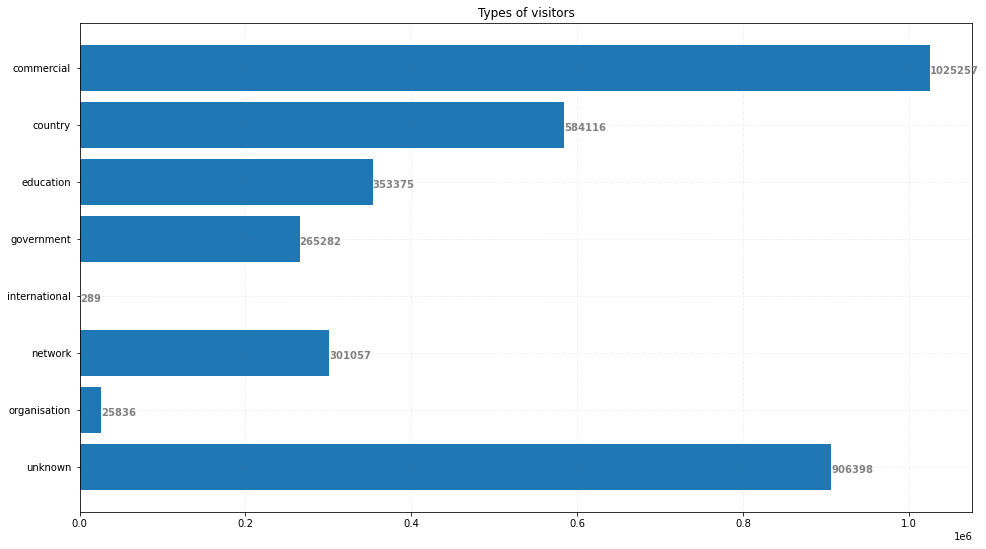

In [8]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['category'])['category'].count().reset_index(name='count')

# horizontal bar plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(df_top_visitors['category'], df_top_visitors['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 3)
ax.yaxis.set_tick_params(pad = 5)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Types of visitors') 
plt.show()


### Timestamp
* Add Month column
* Add Hour column
* Add Mins column

## Identify relationship between features